# Band Excitation data procesing
### Suhas Somnath, Chris R. Smith, Stephen Jesse
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>
9/2/2020

### Reference:
This Jupyter notebook uses [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) to analyze Band Excitation data. We request you to reference the [Arxiv paper](https://arxiv.org/abs/1903.09515) titled "*USID and Pycroscopy - Open frameworks for storing and analyzing spectroscopic and imaging data*" in your publications.  

#### Jupyter Notebooks:
This is a Jupyter Notebook - it contains text and executable code `cells`. To learn more about how to use it, please see [this video](https://www.youtube.com/watch?v=jZ952vChhuI). Please see the image below for some basic tips on using this notebook.

If you have any questions or need help running this notebook, please get in touch with your host if you are a users at the Center for Nanophase Materials Science (CNMS) or our [google group](https://groups.google.com/forum/#!forum/pycroscopy).

![notebook_rules.png](https://raw.githubusercontent.com/pycroscopy/pycroscopy/master/jupyter_notebooks/notebook_rules.png)

Image courtesy of Jean Bilheux from the [neutron imaging](https://github.com/neutronimaging/python_notebooks) GitHub repository.

## Configure the notebook

In [1]:
# Make sure needed packages are installed and up-to-date
from __future__ import division, print_function, absolute_import
import sys
#!conda install --yes --prefix {sys.prefix} numpy scipy matplotlib scikit-learn Ipython ipywidgets h5py 
#!{sys.executable} -m pip install -U --no-deps BGlib  # this will automatically install sidpy and pyUSID as well

In [2]:
# Ensure python 3 compatibility
sys.path.insert(0,r'/Users/rvv/pyUSID')
sys.path.insert(0,r'/Users/rvv/PycharmProjects/sidpy')
sys.path.insert(0,r'/Users/rvv/PycharmProjects/BGlib')


# Import necessary libraries:
# General utilities:
import os

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# The engineering components supporting BGlib:
import sidpy
import pyUSID as usid
# Finally, BGlib itself
from BGlib import be as belib

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
# set up notebook to show plots within the notebook
%matplotlib notebook

## Set some basic preferences
This notebook performs some functional fitting whose duration can be substantially decreased by using more memory and CPU cores. We have provided default values below but you may choose to change them if necessary. Setting `max_cores` to `None` will allow usage of all but one CPU core for the computations. 

By default, results of the functional fitting will be written back to the same HDF5 file. However, if you prefer to write results into different HDF5 files, please set the `results_to_new_file` parameter to `True` instead. Users of the [DataFed](https://datafed.ornl.gov) Scientific Data Management System may want to set this parameter to `True`.

In [4]:
max_mem         = 1024*2  # Maximum memory to use, in Mbs. Default = 1024
max_cores       = None    # Number of logical cores to use in fitting.  None uses all but 2 available cores.
results_to_new_file = False

## Make the data USID compatible
Converting the raw data into a USID formatted hierarchical data format (HDF or .h5) file gives you access to the fast fitting algorithms and powerful analysis functions within the broader pycroscopy ecosystem

#### H5 files:
* are like smart containers that can store matrices with data, folders to organize these datasets, images, metadata like experimental parameters, links or shortcuts to datasets, etc.
* are readily compatible with high-performance computing facilities
* scale very efficiently from few kilobytes to several terabytes
* can be read and modified using any language including Python, Matlab, C/C++, Java, Fortran, Igor Pro, etc.

#### You can load either of the following:
* Any .mat or .txt parameter file from the original experiment
* A .h5 file generated from the raw data using BGlib - skips translation

You can select desired file type by choosing the second option in the pull down menu on the bottom right of the file window

In [5]:
input_file_path = r'/Users/rvv/Dropbox (ORNL)/AE Related Stuff/GPIM for BEPS/test_data/PTO_BEPS/PTO_BEPS_50x50_0002.h5'

In [6]:
(data_dir, filename) = os.path.split(input_file_path)

if input_file_path.endswith('.h5'):
    # No translation here
    h5_path = input_file_path
    force = True # Set this to true to force patching of the datafile.
    tl = belib.translators.LabViewH5Patcher()
    tl.translate(h5_path, force_patch=force)
else:
    # Set the data to be translated
    data_path = input_file_path

    (junk, base_name) = os.path.split(data_dir)

    # Check if the data is in the new or old format.  Initialize the correct translator for the format.
    if base_name == 'newdataformat':
        (junk, base_name) = os.path.split(junk)
        translator = belib.translators.BEPSndfTranslator(max_mem_mb=max_mem)
    else:
        translator = belib.translators.BEodfTranslator(max_mem_mb=max_mem)
    if base_name.endswith('_d'):
        base_name = base_name[:-2]
    # Translate the data
    print(translator)
    h5_path = translator.translate(data_path, show_plots=True, save_plots=False)

In [7]:
h5_file = h5py.File(h5_path, 'r+')

In [8]:
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Raw_Data-SHO_Fit_001
      --------------------
      ├ Fit
      ├ Fit-Loop_Fit_000
        ----------------
        ├ Fit
        ├ Fit_Loop_Parameters
        ├ Guess
        ├ Guess_Loop_Parameters
        ├ Loop_Metrics
        ├ Loop_Metrics_Indices
        ├ Loop_Metrics_Values
        ├ Projected_Loops
        ├ completed_fit_positions
        ├ completed_guess_positions
        ├ completed_positions
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ completed_fit_positions
      ├ completed_guess_positions
      ├ completed_positions
    ├ Spatially_Averaged_Plot_Group_000
     

In [9]:
h5_main = h5_file['Measurement_000/Channel_000/Raw_Data']

In [10]:
h5_main = usid.USIDataset(h5_main)

##### Inspect the contents of this h5 data file
The file contents are stored in a tree structure, just like files on a conventional computer.
The data is stored as a 2D matrix (position, spectroscopic value) regardless of the dimensionality of the data. Thus, the positions will be arranged as row0-col0, row0-col1.... row0-colN, row1-col0.... and the data for each position is stored as it was chronologically collected  

The main dataset is always accompanied by four ancillary datasets that explain the position and spectroscopic value of any given element in the dataset.

In [11]:
print('Datasets and datagroups within the file:\n------------------------------------')
sidpy.hdf.hdf_utils.print_tree(h5_file)
 
print('\nThe main dataset:\n------------------------------------')
print(h5_main)

print('\nMetadata or attributes in the measurement datagroup\n------------------------------------')
for key, val in sidpy.hdf.hdf_utils.get_attributes(h5_main.parent.parent).items():
    print('{} : {}'.format(key, val))

Datasets and datagroups within the file:
------------------------------------
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Raw_Data-SHO_Fit_001
      --------------------
      ├ Fit
      ├ Fit-Loop_Fit_000
        ----------------
        ├ Fit
        ├ Fit_Loop_Parameters
        ├ Guess
        ├ Guess_Loop_Parameters
        ├ Loop_Metrics
        ├ Loop_Metrics_Indices
        ├ Loop_Metrics_Values
        ├ Projected_Loops
        ├ completed_fit_positions
        ├ completed_guess_positions
        ├ completed_positions
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ completed_fit_positions
      ├ completed_guess_posit

## Get some basic parameters from the H5 file
This information will be vital for futher analysis and visualization of the data

In [12]:
h5_pos_inds = h5_main.h5_pos_inds
pos_dims = h5_main.pos_dim_sizes
pos_labels = h5_main.pos_dim_labels
print(pos_labels, pos_dims)

h5_meas_grp = h5_main.parent.parent

parm_dict = sidpy.hdf.hdf_utils.get_attributes(h5_meas_grp)

expt_type = sidpy.hdf.hdf_utils.get_attr(h5_file, 'data_type')

is_ckpfm = expt_type == 'cKPFMData'
if is_ckpfm:
    num_write_steps = parm_dict['VS_num_DC_write_steps']
    num_read_steps = parm_dict['VS_num_read_steps']
    num_fields = 2
    
if expt_type != 'BELineData':
    vs_mode = sidpy.hdf.hdf_utils.get_attr(h5_meas_grp, 'VS_mode')
    try:
        field_mode = sidpy.hdf.hdf_utils.get_attr(h5_meas_grp, 'VS_measure_in_field_loops')
    except KeyError:
        print('field mode could not be found. Setting to default value')
        field_mode = 'out-of-field'
    try:
        vs_cycle_frac = sidpy.hdf.hdf_utils.get_attr(h5_meas_grp, 'VS_cycle_fraction')
    except KeyError:
        print('VS cycle fraction could not be found. Setting to default value')
        vs_cycle_frac = 'full'

['X', 'Y'] [50, 50]


## Visualize the raw data
Use the sliders below to visualize spatial maps (2D only for now), and spectrograms.
For simplicity, all the spectroscopic dimensions such as frequency, excitation bias, cycle, field, etc. have been collapsed to a single slider.

No position datasets found as attributes of /Measurement_000/Channel_000/Spectroscopic_Values


<IPython.core.display.Javascript object>


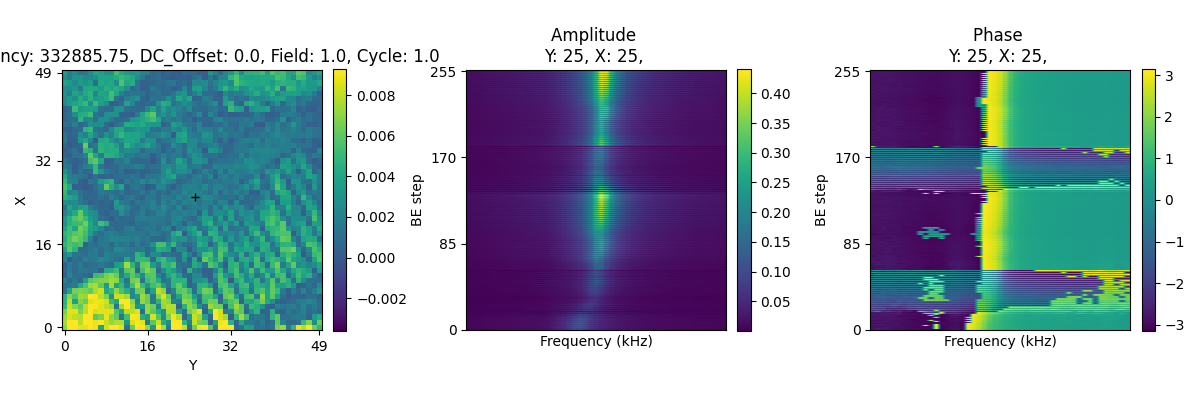

interactive(children=(IntSlider(value=0, description='Step', max=12544), Output()), _dom_classes=('widget-inte…

In [13]:
fig = belib.viz.be_viz_utils.jupyter_visualize_be_spectrograms(h5_main)

## Fit the Band Excitation (BE) spectra
Fit each of the acquired spectra to a simple harmonic oscillator (SHO) model to extract the following information regarding the response:
* Oscillation amplitude
* Phase
* Resonance frequency
* Quality factor

By default, the cell below will take any previous result instead of re-computing the SHO fit

In [14]:
sho_fit_points = 5  # The number of data points at each step to use when fitting
sho_override = False  # Force recompute if True

h5_sho_targ_grp = None
if results_to_new_file:
    h5_sho_file_path = os.path.join(folder_path, 
                                h5_raw_file_name.replace('.h5', '_sho_fit.h5'))
    print('\n\nSHO Fits will be written to:\n' + h5_sho_file_path + '\n\n')
    f_open_mode = 'w'
    if os.path.exists(h5_sho_file_path):
        f_open_mode = 'r+'
    h5_sho_file = h5py.File(h5_sho_file_path, mode=f_open_mode)
    h5_sho_targ_grp = h5_sho_file
    
sho_fitter = belib.analysis.BESHOfitter(h5_main, cores=max_cores, verbose=False, h5_target_group=h5_sho_targ_grp)
sho_fitter.set_up_guess(guess_func=belib.analysis.be_sho_fitter.SHOGuessFunc.complex_gaussian,
                        num_points=sho_fit_points)
h5_sho_guess = sho_fitter.do_guess(override=sho_override)
sho_fitter.set_up_fit()
h5_sho_fit = sho_fitter.do_fit(override=sho_override)
h5_sho_grp = h5_sho_fit.parent

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file
Group: <HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000" (3 members)> had neither the status HDF5 dataset or the legacy attribute: "last_pixel".

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_001" (8 members)>]

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_001" (8 members)>]
Returned previously computed results at /Measurement_000/Channel_000/Raw_Data-SHO_Fit_001

Note: SHO_Fit has already been performed with the same parameters before. These results will 

## Visualize the SHO results
Here, we visualize the parameters for the SHO fits. BE-line (3D) data is visualized via simple spatial maps of the SHO parameters while more complex BEPS datasets (4+ dimensions) can be visualized using a simple interactive visualizer below. 

You can choose to visualize the guesses for SHO function or the final fit values from the first line of the cell below.

Use the sliders below to inspect the BE response at any given location. 

In [15]:
h5_sho_spec_inds = h5_sho_fit.h5_spec_inds
sho_spec_labels = h5_sho_fit.spec_dim_labels

if is_ckpfm:
    # It turns out that the read voltage index starts from 1 instead of 0
    # Also the VDC indices are NOT repeating. They are just rising monotonically
    write_volt_index = np.argwhere(sho_spec_labels == 'write_bias')[0][0]
    read_volt_index = np.argwhere(sho_spec_labels == 'read_bias')[0][0]
    h5_sho_spec_inds[read_volt_index, :] -= 1
    h5_sho_spec_inds[write_volt_index, :] = np.tile(np.repeat(np.arange(num_write_steps), num_fields), num_read_steps)

(Nd_mat, success, nd_labels) = usid.hdf_utils.reshape_to_n_dims(h5_sho_fit, get_labels=True)
print('Reshape Success: ' + str(success))

print(nd_labels)
print(Nd_mat.shape)

Reshape Success: True
['X' 'Y' 'DC_Offset' 'Field' 'Cycle']
(50, 50, 64, 2, 2)


No position datasets found as attributes of /Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Spectroscopic_Indices
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Spectroscopic_Values


<IPython.core.display.Javascript object>


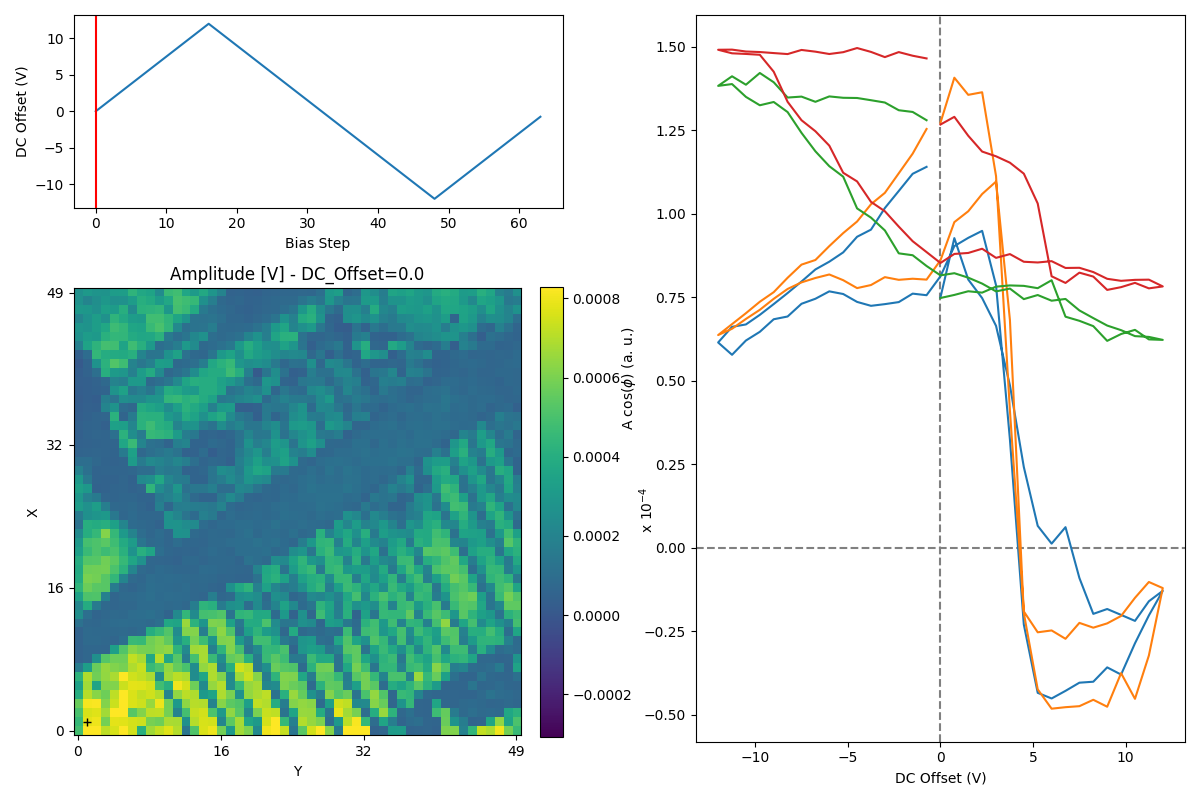

interactive(children=(Dropdown(description='SHO Quantity', options=('Amplitude [V]', 'Frequency [Hz]', 'Qualit…

In [16]:
use_sho_guess = False
use_static_viz_func = False

if use_sho_guess:
    sho_dset = h5_sho_guess
else:
    sho_dset = h5_sho_fit
  
if expt_type == 'BELineData' or len(pos_dims) != 2:
    use_static_viz_func = True
    step_chan = None
else:
    if vs_mode not in ['AC modulation mode with time reversal', 
                                                      'DC modulation mode']:
        use_static_viz_func = True
    else:
        if vs_mode == 'DC modulation mode':
            step_chan = 'DC_Offset'
        else:
            step_chan = 'AC_Amplitude'
if not use_static_viz_func:
    try:
        # use interactive visualization
        belib.viz.be_viz_utils.jupyter_visualize_beps_sho(sho_dset, step_chan)
    except:
        raise
        print('There was a problem with the interactive visualizer')
        use_static_viz_func = True
else:
    chan_grp = h5_main.parent
    meas_grp = chan_grp.parent
    # show plots of SHO results vs. applied bias
    figs = belib.viz.be_viz_utils.visualize_sho_results(sho_dset, show_plots=True, save_plots=False, 
                                                     expt_type=expt_type, meas_type='None', 
                                                     )

## Fit loops to a function
This is applicable only to DC voltage spectroscopy datasets from BEPS. The PFM hysteresis loops in this dataset will be projected to maximize the loop area and then fitted to a function.

Note: This computation generally takes a while for reasonably sized datasets.

In [17]:
# Do the Loop Fitting on the SHO Fit dataset
loop_success = False

h5_loop_group = None
if results_to_new_file:
    h5_loop_file_path = os.path.join(folder_path, 
                                     h5_raw_file_name.replace('.h5', '_loop_fit.h5'))
    print('\n\nLoop Fits will be written to:\n' + h5_loop_file_path + '\n\n')
    f_open_mode = 'w'
    if os.path.exists(h5_loop_file_path):
        f_open_mode = 'r+'
    h5_loop_file = h5py.File(h5_loop_file_path, mode=f_open_mode)
    h5_loop_group = h5_loop_file
        
loop_fitter = belib.analysis.BELoopFitter(h5_sho_fit, expt_type, vs_mode, vs_cycle_frac,
                                       cores=max_cores, h5_target_group=h5_loop_group, 
                                       verbose=False)
loop_fitter.set_up_guess()
h5_loop_guess = loop_fitter.do_guess(override=False)
# Calling explicitely here since Fitter won't do it automatically
h5_guess_loop_parms = loop_fitter.extract_loop_parameters(h5_loop_guess)

loop_fitter.set_up_fit()
h5_loop_fit = loop_fitter.do_fit(override=False)
h5_loop_group = h5_loop_fit.parent
loop_success = True

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit-Loop_Fit_000" (11 members)>]

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit-Loop_Fit_000" (11 members)>]
Returned previously computed results at /Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit-Loop_Fit_000


/Users/rvv/pyUSID/pyUSID/io/hdf_utils/simple.py:949: UserWarning: A dataset named: Guess_Loop_Parameters already exists in group: /Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))
/Users/rvv/pyUSID/pyUSID/io/hdf_utils/simple.py:300: UserWarning: pyUSID.io.hdf_utils.simple.copy_attributes no longer copies region references. Please use pyUSID.io.reg_ref.copy_region_refs to copy references manually
  warn('pyUSID.io.hdf_utils.simple.copy_attributes no longer copies '



Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit-Loop_Fit_000" (11 members)>]
Returned previously computed results at /Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit-Loop_Fit_000


/Users/rvv/pyUSID/pyUSID/io/hdf_utils/simple.py:949: UserWarning: A dataset named: Fit_Loop_Parameters already exists in group: /Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))
/Users/rvv/pyUSID/pyUSID/io/hdf_utils/simple.py:300: UserWarning: pyUSID.io.hdf_utils.simple.copy_attributes no longer copies region references. Please use pyUSID.io.reg_ref.copy_region_refs to copy references manually
  warn('pyUSID.io.hdf_utils.simple.copy_attributes no longer copies '


## Prepare datasets for visualization

In [18]:
# Prepare some variables for plotting loops fits and guesses
# Plot the Loop Guess and Fit Results
if loop_success:
    h5_projected_loops = usid.USIDataset(h5_loop_guess.parent['Projected_Loops'])
    h5_proj_spec_inds = h5_projected_loops.h5_spec_inds
    h5_proj_spec_vals = h5_projected_loops.h5_spec_vals

    # reshape the vdc_vec into DC_step by Loop
    sort_order = usid.hdf_utils.get_sort_order(h5_proj_spec_inds)
    dims = usid.hdf_utils.get_dimensionality(h5_proj_spec_inds[()], 
                                           sort_order[::-1])
    vdc_vec = np.reshape(h5_proj_spec_vals[h5_projected_loops.spec_dim_descriptors.index('DC_Offset (V)')], dims).T

    #Also reshape the projected loops to Positions-DC_Step-Loop
    # Also reshape the projected loops to Positions-DC_Step-Loop
    proj_nd = h5_projected_loops.get_n_dim_form()
    proj_3d = np.reshape(proj_nd, [h5_projected_loops.shape[0], 
                                   proj_nd.shape[2], -1])

## Visualize Loop fits

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Spectroscopic_Values


<IPython.core.display.Javascript object>


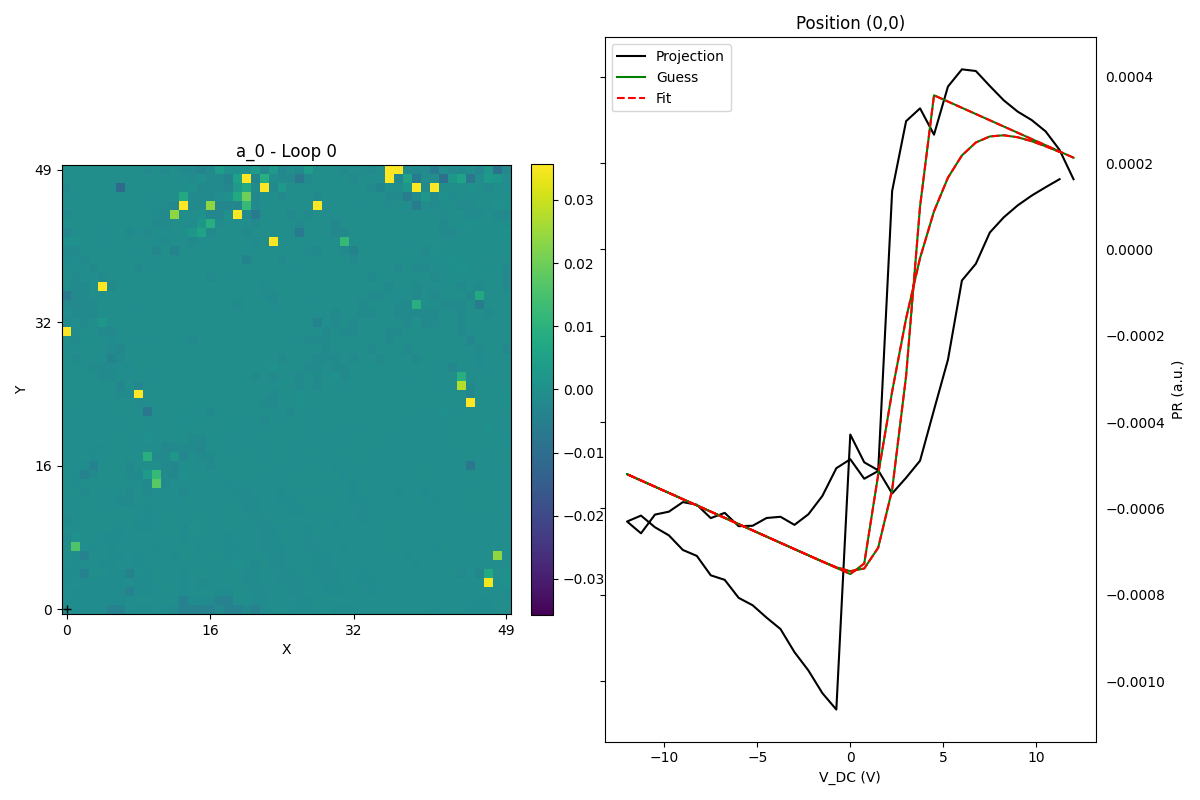

interactive(children=(Dropdown(description='loop_field', options=('a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'b_0', 'b…

In [19]:
use_static_plots = False
if loop_success:
    if not use_static_plots:
        try:
            fig = belib.viz.be_viz_utils.jupyter_visualize_beps_loops(h5_projected_loops, h5_loop_guess, h5_loop_fit)
        except:
            print('There was a problem with the interactive visualizer')
            use_static_plots = True
    if use_static_plots:
        for iloop in range(h5_loop_guess.shape[1]):
            fig, ax = belib.viz.be_viz_utils.plot_loop_guess_fit(vdc_vec[:, iloop], proj_3d[:, :, iloop], 
                                          h5_loop_guess[:, iloop], h5_loop_fit[:, iloop],
                                          title='Loop {} - All Positions'.format(iloop))

## Loop Parameters
We will now load the loop parameters caluculated from the fit and plot them.

<IPython.core.display.Javascript object>


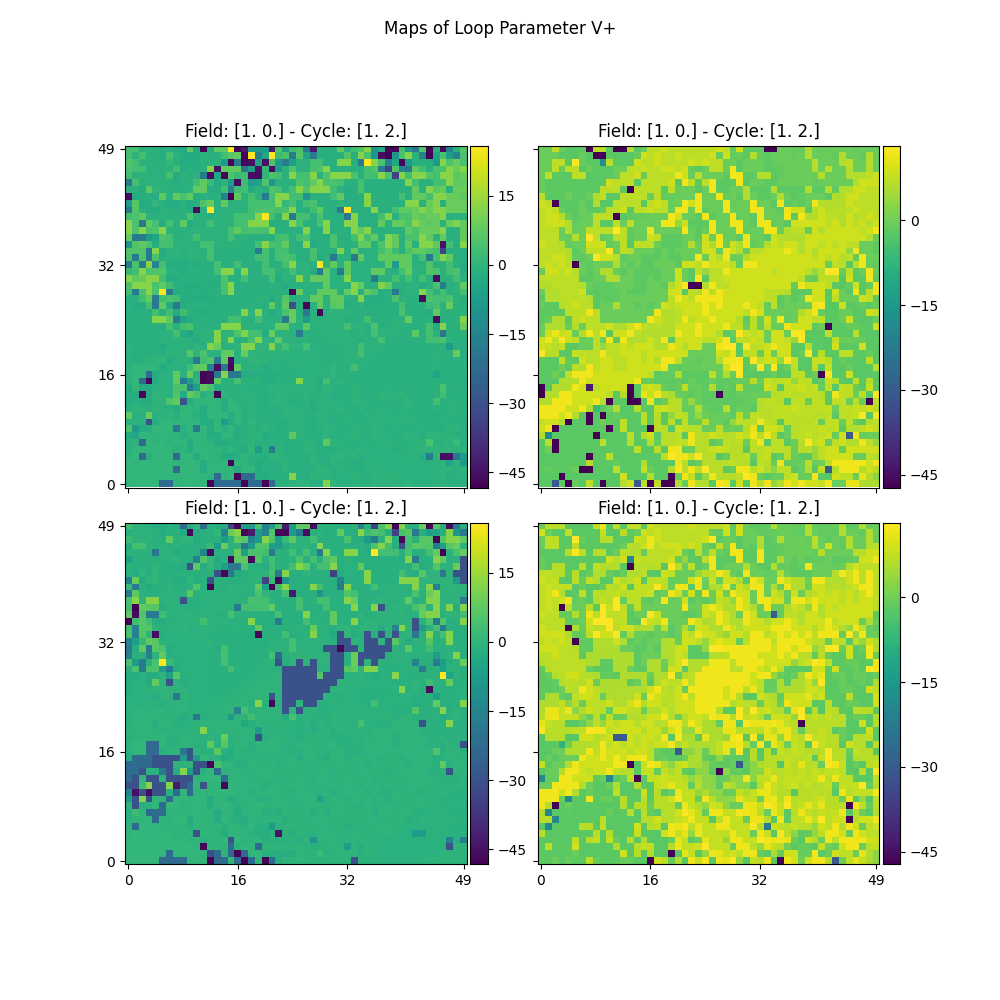

/Users/rvv/PycharmProjects/sidpy/sidpy/viz/plot_utils/image.py:395: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  cb = axes.cbar_axes[count].colorbar(im)
//anaconda3/lib/python3.7/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


interactive(children=(Dropdown(description='parameter_name', options=('V+', 'V-', 'Imprint', 'R+', 'R-', 'Swit…

In [20]:
h5_loop_parameters = h5_loop_group['Fit_Loop_Parameters']
fig = belib.viz.be_viz_utils.jupyter_visualize_parameter_maps(h5_loop_parameters)

(12544,)


<IPython.core.display.Javascript object>


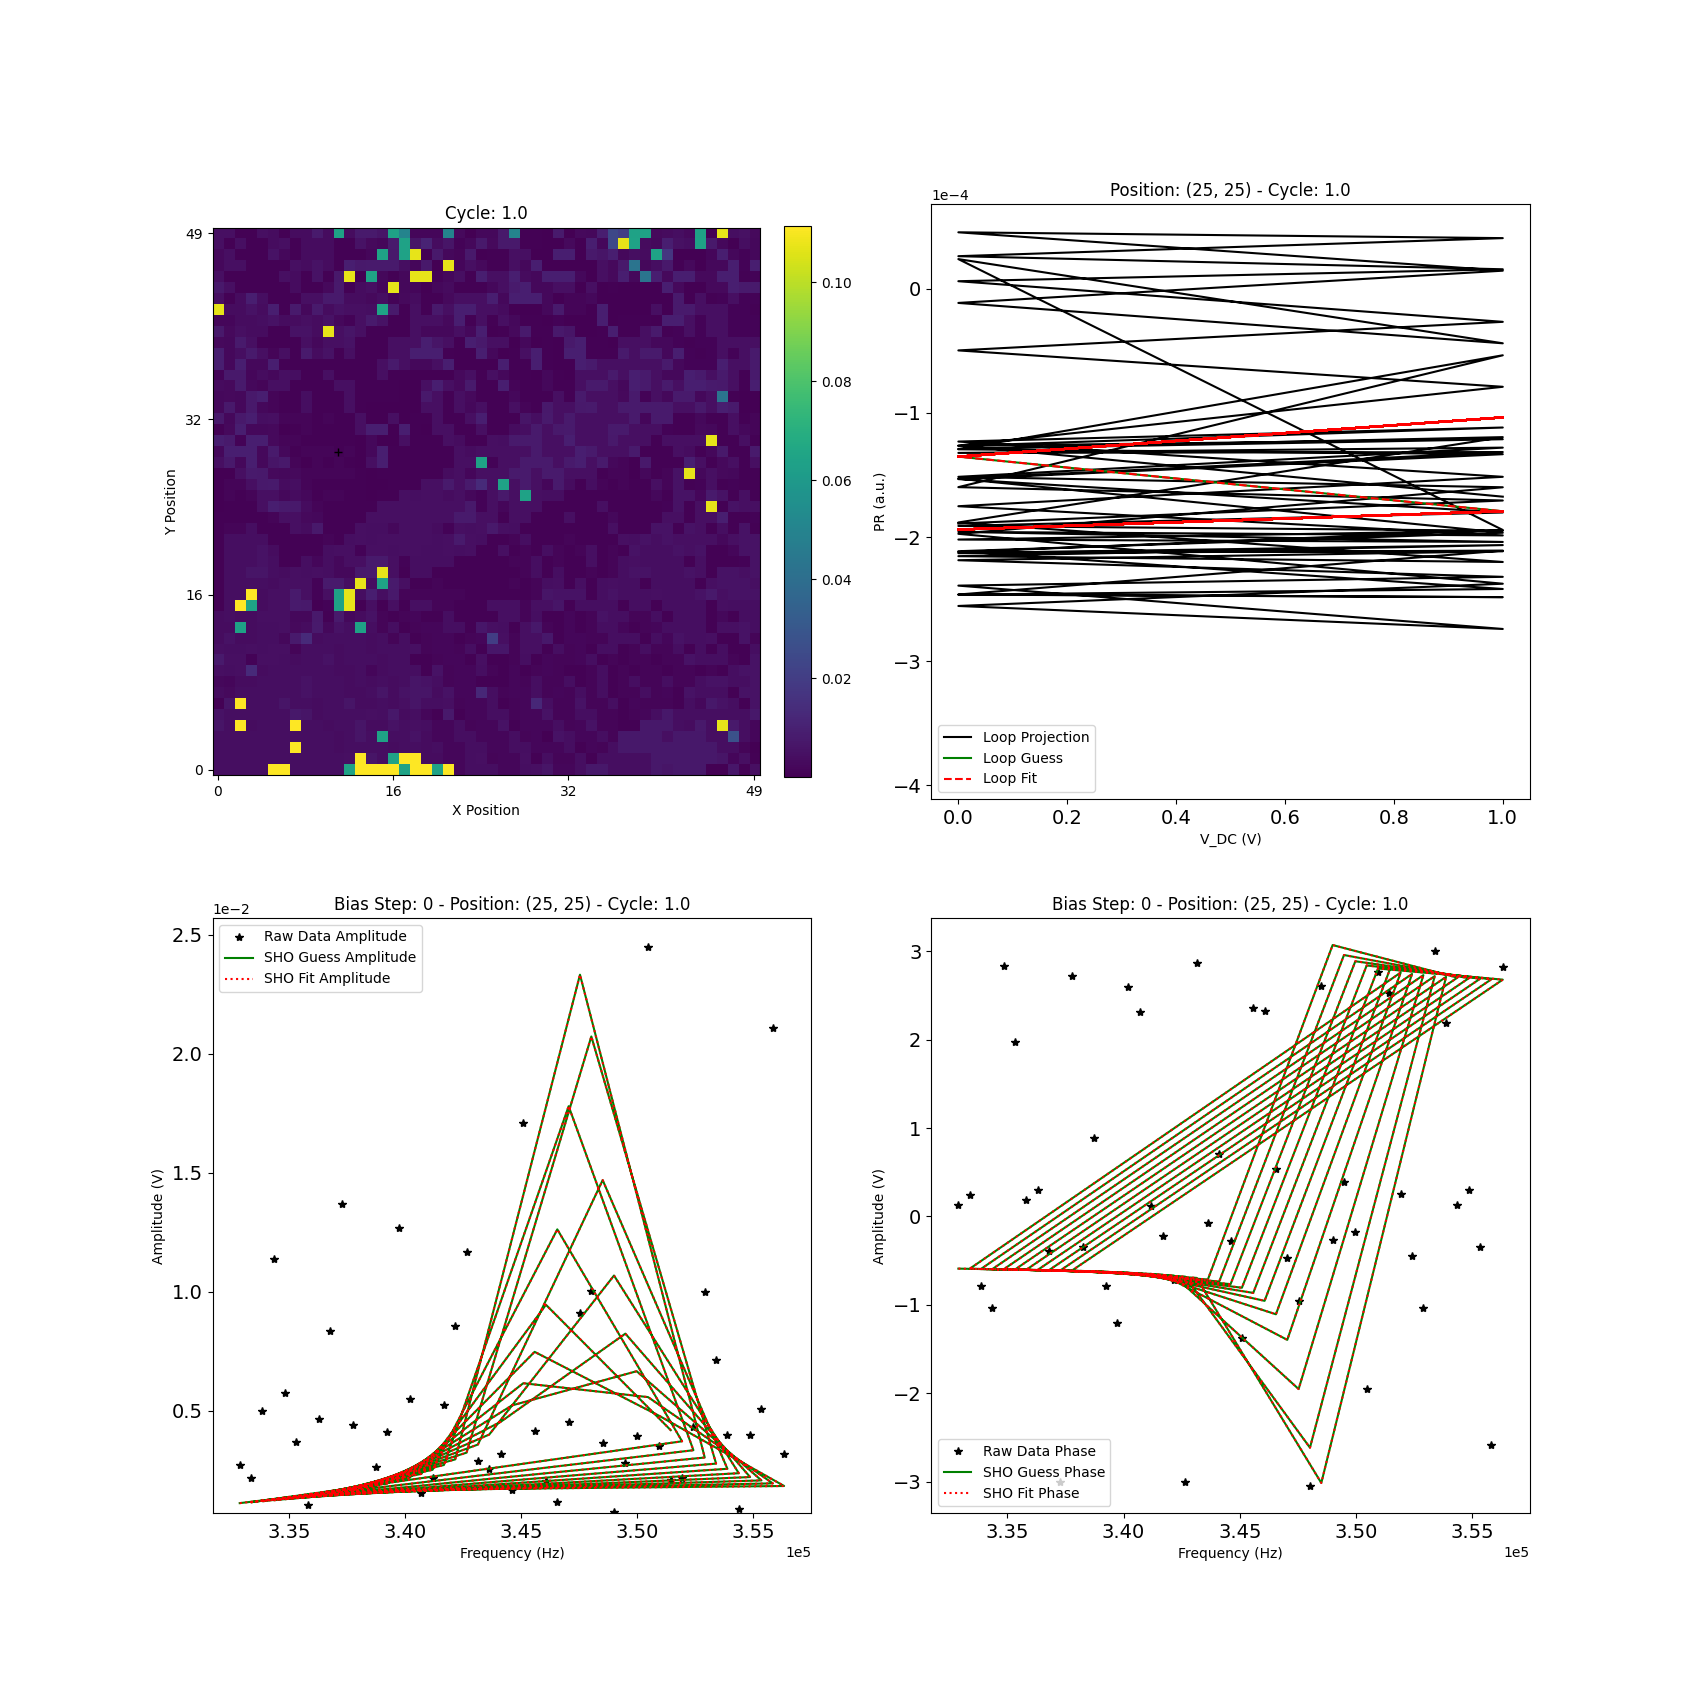

interactive(children=(Dropdown(description='selected_loop_parm', index=6, options=('V+', 'V-', 'Imprint', 'R+'…

interactive(children=(IntSlider(value=0, description='selected_loop_cycle', max=3), Output()), _dom_classes=('…

interactive(children=(IntSlider(value=0, description='selected_step', max=63), Output()), _dom_classes=('widge…

In [21]:
map_parm = 'Work of Switching'
plot_cycle = 0
plot_position = (int(pos_dims[0]/2), int(pos_dims[1]/2))
plot_bias_step = 0

fig = belib.viz.be_viz_utils.plot_loop_sho_raw_comparison(h5_loop_parameters, h5_sho_grp, h5_main,
                                                       selected_loop_parm=map_parm, 
                                                       selected_loop_cycle=plot_cycle, 
                                                       selected_loop_pos=plot_position, 
                                                       selected_step=plot_bias_step)


In [22]:
h5_main_spec_vals = h5_main.h5_spec_vals

full_w_vec = h5_main_spec_vals[h5_main.spec_dim_descriptors.index('Frequency (Hz)')]

<IPython.core.display.Javascript object>


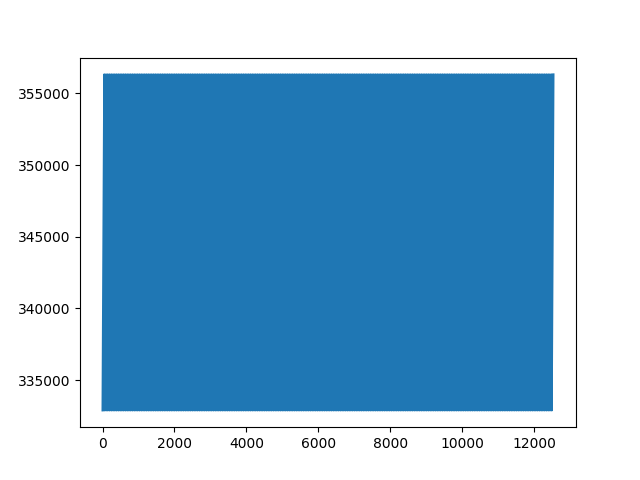

In [23]:
plt.figure()
plt.plot(full_w_vec)

In [24]:
full_w_vec2 = full_w_vec.reshape(tuple(h5_main.spec_dim_sizes))

In [25]:
tuple(h5_main.spec_dim_sizes)

(49, 64, 2, 2)

## Save and close
* Save the .h5 file that we are working on by closing it. <br>
* Also, consider exporting this notebook as a notebook or an html file. <br> To do this, go to File >> Download as >> HTML
* Finally consider saving this notebook if necessary

In [26]:
h5_main.spec_dim_descriptors.index('Frequency (Hz)')

0

In [27]:
h5_file.close()
if results_to_new_file:
    h5_sho_fit.file.close()
    h5_loop_fit.file.close()